# FIGARO: skymaps

This notebook shows how to use FIGARO to reconstruct the skymap of a gravitational wave event given a set of posterior samples.

## Prerequisites

This notebook makes use of the PE samples from the various GWTC data release. FIGARO comes with GW150914 posterior samples in .hdf5 format. The GWTC data releases are available via [GWOSC](https://www.gw-openscience.org).

In the following we will make use of a preprocessed version of [GLADE+](http://glade.elte.hu).\
The catalog file is ~1.2 GB (the original .txt file is ~6 GB), therefore is not attached to FIGARO.\
Before running this notebook, please download GLADE+ from the website and preprocess via `figaro-glade -i path/to/glade+.txt`. This will create, in the same folder as `glade+.txt`, `glade+.hdf5`.

Once done, please provide the location of your `glade+.hdf5` file: 

In [1]:
glade_file = 'path/to/glade+.hdf5'

## GW150914

### Loading posterior samples

First of all, we need to load the posterior samples from the `.hdf5` file. FIGARO provides an ad-hoc module, `figaro.load`:

In [2]:
from figaro.load import load_single_event
import numpy as np

samples, name = load_single_event('./data/GW150914_GWTC-1.hdf5', par = ['ra', 'dec', 'luminosity_distance'])

Please note the order of the parameters: the module we are going to use expects them to be in this precise order:
$(\alpha,\delta,D_L)$.

Another possibility is to use the `volume` argument: in this case, `load_single_event` returns the correct parameters in the correct order. Please keep in mind that, with unstructured data, both `par` and `volume` are ignored, therefore it is up to the user to check that the input file contains the correct data in the correct order.

In [3]:
samples, name = load_single_event('./data/GW150914_GWTC-1.hdf5', volume = True)

Let's have a quick glance at the samples:

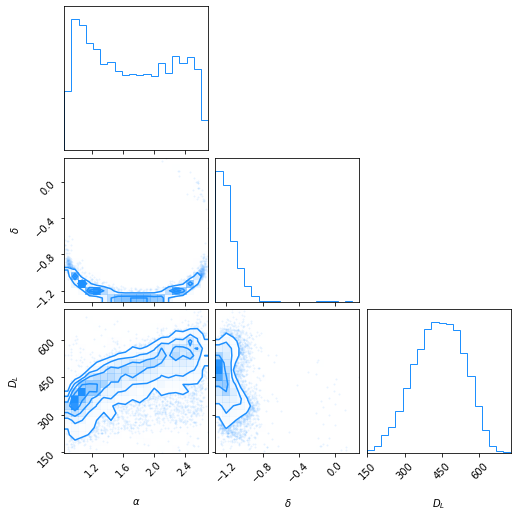

In [4]:
from corner import corner

c = corner(samples, labels = ['$\\alpha$', '$\\delta$', '$D_L$'], color = 'dodgerblue')

The class we want to use to analyse these samples is `figaro.threeDvolume.VolumeReconstruction`:

In [5]:
from figaro.threeDvolume import VolumeReconstruction

This class takes several parameters (only one of them is mandatory, though). Here we report the ones which are most useful for a turnkey use, postponing the others :
 * `max_dist`, **mandatory**: upper bound of the distance prior in Mpc. The other end is set, by default, to 0. Beware that setting `max_dist = max(samples[:,2])` is not allowed and raises an exception. This is intentional: FIGARO does not allow the user to determine parameter space bounds directly using samples values;
 * `out_folder`: folder where to save the outputs;
 * `n_gridpoints`: number of grid points for each parameter. Default is 720 for $\alpha$, 360 for $\delta$ ($0.25\ \mathrm{deg}^2$ resolution) and 100 for $D_L$. For a quicker run,  which however gives a less precise skymap, use smaller numbers;
 * `name`: event name, to be given to outputs;
 * `latex`: use LaTeX in plots (it takes a bit longer to produce outputs, but they are nicer).

In this example, the maximum distance will be set to 1000 Mpc. Instancing the `VolumeReconstruction` with default values takes around a minute because it needs to compute a 720x360x100 grid.

In [6]:
d_max = 1000

mix = VolumeReconstruction(max_dist   = d_max,
                           out_folder = './skymap_test',
                           name       = name,
                           latex      = True,
                           )

`VolumeReconstruction` works identically to `figaro.mixture.DPGMM`. To reconstruct the skymap, just use the `density_from_samples` method:

In [ ]:
mix.density_from_samples(samples)

GW150914_GWTC-1: 100%|█████████████████████| 8350/8350 [00:13<00:00, 607.20it/s]


The skymap is stored in `out_folder/skymaps/name/`:

In [ ]:
from IPython.display import Markdown as md
from pathlib import Path

file = Path(mix.out_folder.parts[-1], 'skymaps', mix.name, mix.name+'_all.pdf')
mdcommand = "![SegmentLocal]({})".format(file)
md(mdcommand)

FIGARO can also provide intermediate sky maps while inferring the mixture.
The appropriate keyword, in this case, is `incr_plot`.

**NB:** the keywords presented here (and in the following) can be used while instanciating the class as well as during the initialisation. In this notebook, we will rely on the latter in order to avoid re-computing the volume grid for every example.

In [ ]:
mix.initialise(out_folder = 'skymap_incr', incr_plot = True)

np.random.shuffle(samples)
mix.density_from_samples(samples)

The skymap evolution is shown in this pretty GIF:

In [ ]:
mdcommand = "![SegmentLocal]({})".format(Path(mix.out_folder.parts[-1], 'gif', mix.name+'.gif'))
md(mdcommand)

The evolution of the credible volume/area:

In [ ]:
mdcommand = "![SegmentLocal]({})".format(Path(mix.out_folder.parts[-1], 'CR', mix.name+'.pdf'))
md(mdcommand)

Using the information entropy of the distribution, we made FIGARO capable of deciding on its own when to start producing skymaps - we refer the interested user to the methods paper [Rinaldi & Del Pozzo (in preparation)](https://en.uncyclopedia.co/wiki/Frankly_Disappointing_Telescope) for further details.\
This feature is activated by the `entropy` keyword.

In [ ]:
mix.initialise(out_folder = 'skymap_entropy', incr_plot = False, entropy = True)

np.random.shuffle(samples)
mix.density_from_samples(samples)

The `skymap_entropy/skymap/GW150914_GWTC-1` now contains two (or more, if you run this notebook more than once) skymaps: one produced as soon as the entropy derivative changes sign 5 times and the other produced at the end of the run.

In [ ]:
fdr = Path(mix.out_folder.parts[-1], 'skymaps', mix.name)

mdcommand = " ".join(["![SegmentLocal]({})".format(str(file)) for file in list(fdr.glob('GW*'))])
md(mdcommand)

It is also possible to have a look at the entropy evolution and at its angular coefficient:

In [ ]:
fdr = Path(mix.out_folder.parts[-1], 'entropy')

mdcommand = " ".join(["![SegmentLocal]({})".format(str(file)) for file in list(fdr.glob('*{0}.pdf'.format(mix.name)))])
md(mdcommand)